# Curso de Manejo de Datos Faltantes: Imputación

## Configuración de ambiente de trabajo

```bash
pip install --upgrade pip
```

```bash
pip install pyjanitor matplotlib missingno nhanes pandas scipy seaborn session-info sklearn statsmodels upsetplot
```

or 

```bash
pip install -r requirements.txt
```

## Importar librerías

In [29]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

## Importar funciones personalizadas

In [30]:
%run pandas-missing-extension.ipynb

## Configurar el aspecto general de las gráficas del proyecto

In [31]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (8, 6)
    }
)

sns.set_style("whitegrid")

## El problema de trabajar con valores faltantes

In [32]:
airquality_df = (
    sm.datasets.get_rdataset("airquality")
    .data
    .clean_names(
        case_type = "snake"
    )
    .add_column("year", 1973)
    .assign(
        date = lambda df: pd.to_datetime(df[["year", "month", "day"]])
    )
    .sort_values(by = "date")
    .set_index("date")
)

airquality_df

/home/tux/curso-datos-faltantes-i/env/lib/python3.10/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.assign` instead.
  return method(self._obj, *args, **kwargs)


,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


In [33]:
(
    smf.ols(
        formula="temp ~ ozone",
        data=airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.488
Model:,OLS,Adj. R-squared:,0.483
Method:,Least Squares,F-statistic:,108.5
Date:,"Sat, 09 Sep 2023",Prob (F-statistic):,2.93e-18
Time:,08:55:04,Log-Likelihood:,-386.27
No. Observations:,116,AIC:,776.5
Df Residuals:,114,BIC:,782.1
Df Model:,1,,
Covariance Type:,nonrobust,,


In [34]:
(
    smf.ols(
        formula="temp ~ ozone + solar_r",
        data=airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.491
Model:,OLS,Adj. R-squared:,0.481
Method:,Least Squares,F-statistic:,52.07
Date:,"Sat, 09 Sep 2023",Prob (F-statistic):,1.47e-16
Time:,08:55:04,Log-Likelihood:,-369.78
No. Observations:,111,AIC:,745.6
Df Residuals:,108,BIC:,753.7
Df Model:,2,,
Covariance Type:,nonrobust,,


### Reto: Datos de supervivientes

In [35]:
survival_df = sm.datasets.get_rdataset("flchain", "survival").data
survival_df

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death,chapter
0,97,F,1997,5.700,4.860,10,1.7,0,85,1,Circulatory
1,92,F,2000,0.870,0.683,1,0.9,0,1281,1,Neoplasms
2,94,F,1997,4.360,3.850,10,1.4,0,69,1,Circulatory
3,92,F,1996,2.420,2.220,9,1.0,0,115,1,Circulatory
4,93,F,1996,1.320,1.690,6,1.1,0,1039,1,Circulatory
...,...,...,...,...,...,...,...,...,...,...,...
7869,52,F,1995,1.210,1.610,6,1.0,0,4997,0,NaN
7870,52,F,1999,0.858,0.581,1,0.8,0,3652,0,NaN
7871,54,F,2002,1.700,1.720,8,NaN,0,2507,0,NaN
7872,53,F,1995,1.710,2.690,9,NaN,0,4982,0,NaN


Ajusta algunos modelos utilizando a las variables con valores faltantes como predictoras. ¿Qué sucede?

In [36]:
survival_df.shape

(7874, 11)

In [37]:
survival_df.missing.missing_variable_summary()

,variable,n_missing,n_cases,pct_missing
0,age,0,7874,0.000000
1,sex,0,7874,0.000000
2,sample.yr,0,7874,0.000000
3,kappa,0,7874,0.000000
4,lambda,0,7874,0.000000
5,flc.grp,0,7874,0.000000
6,creatinine,1350,7874,17.145034
7,mgus,0,7874,0.000000
8,futime,0,7874,0.000000
9,death,0,7874,0.000000


In [38]:
(
    survival_df
    .missing
    .missing_variable_span(
        variable="chapter",
        span_every=1000
    )
)

,span_counter,n_missing,n_complete,pct_missing,pct_complete
0,0,195,805,19.500000,80.500000
1,1,565,435,56.500000,43.500000
2,2,618,382,61.800000,38.200000
3,3,806,194,80.600000,19.400000
4,4,882,118,88.200000,11.800000
5,5,895,105,89.500000,10.500000
6,6,910,90,91.000000,9.000000
7,7,834,40,95.423341,4.576659


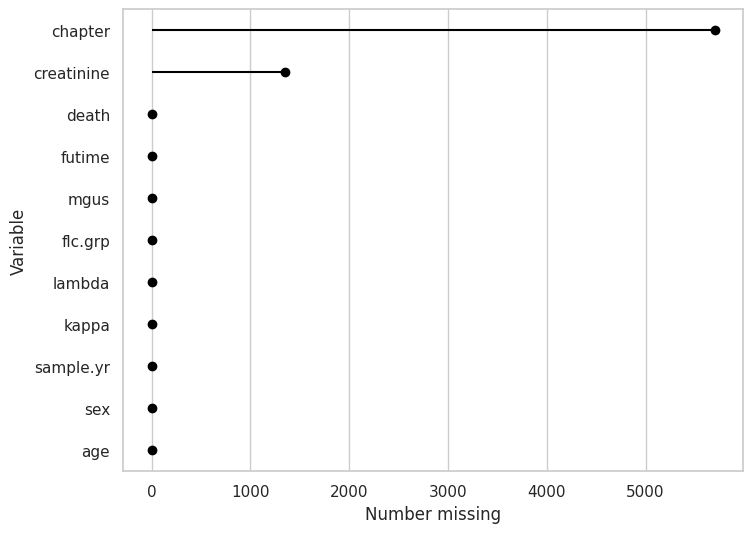

In [39]:
survival_df.missing.missing_variable_plot()

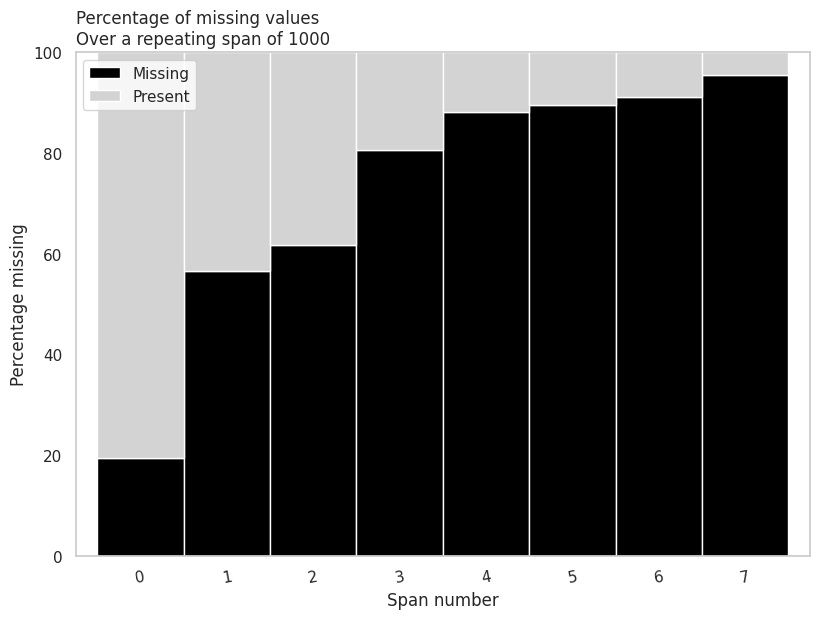

In [40]:
(
    survival_df
    .missing
    .missing_variable_span_plot(
        variable="chapter",
        span_every=1000,
        rot=10
    )
)

<Axes: >

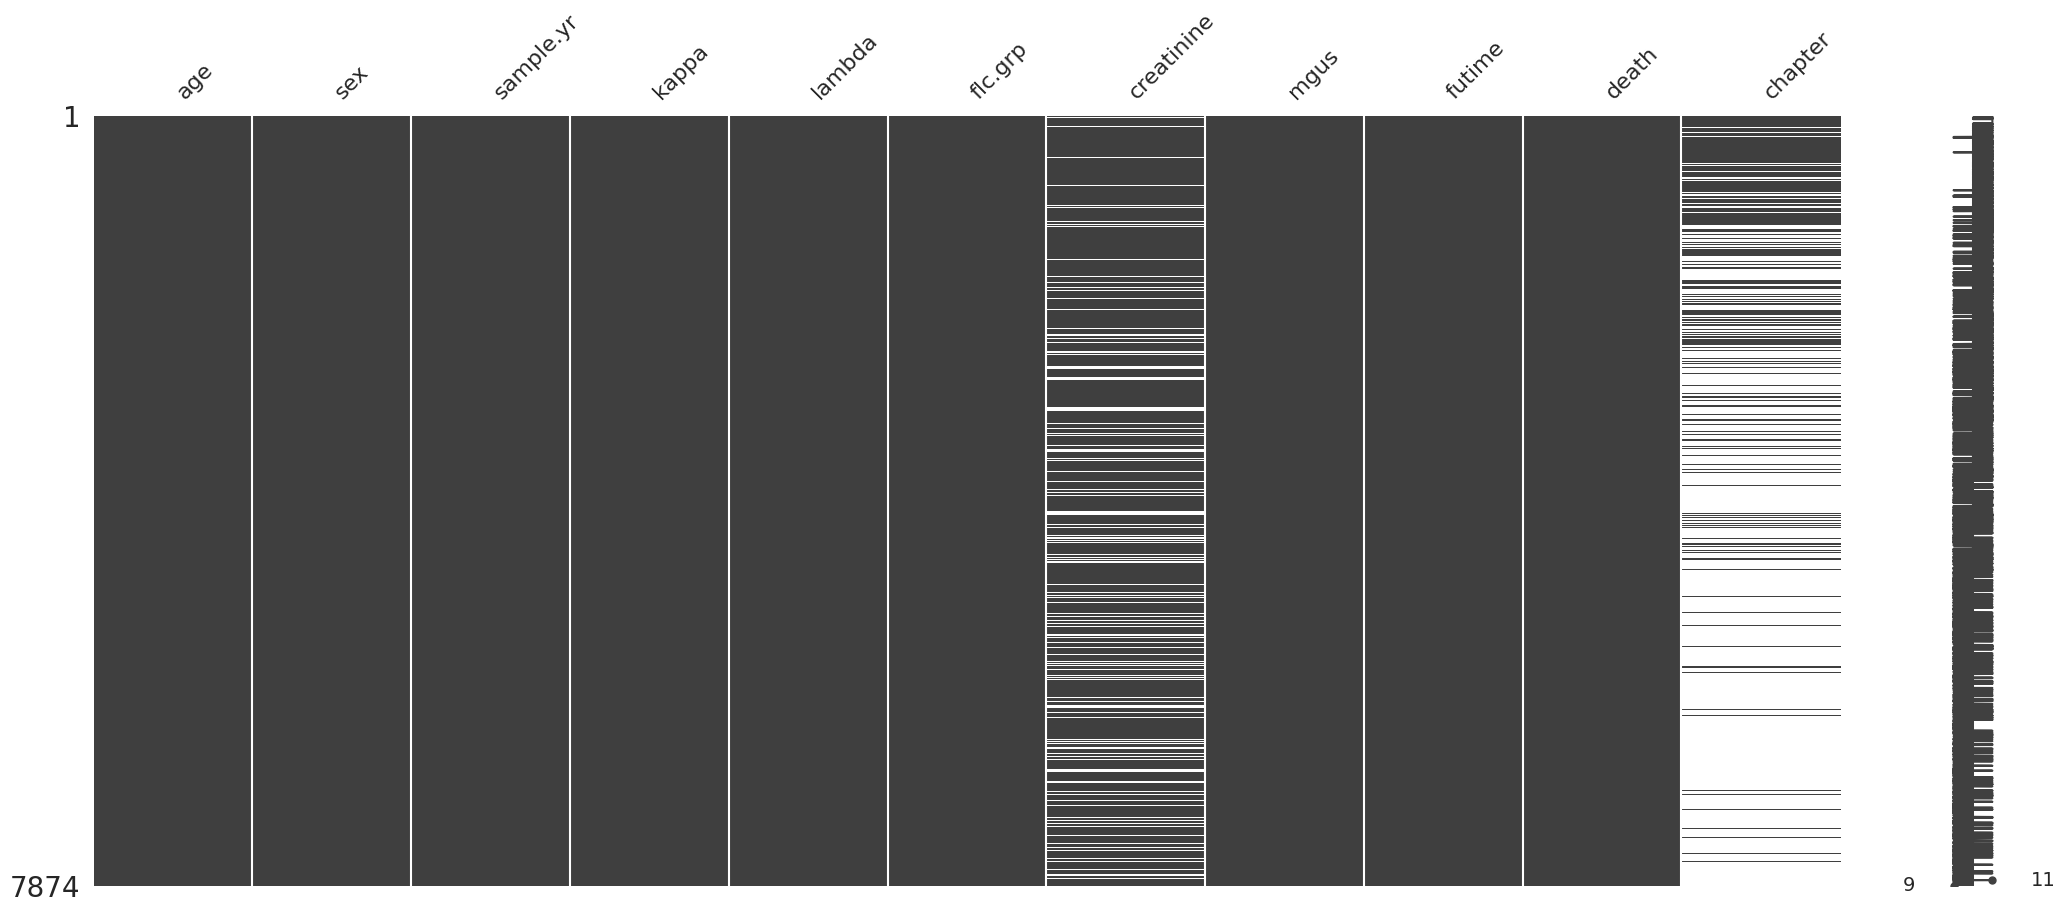

In [41]:
missingno.matrix(df = survival_df)

<Axes: >

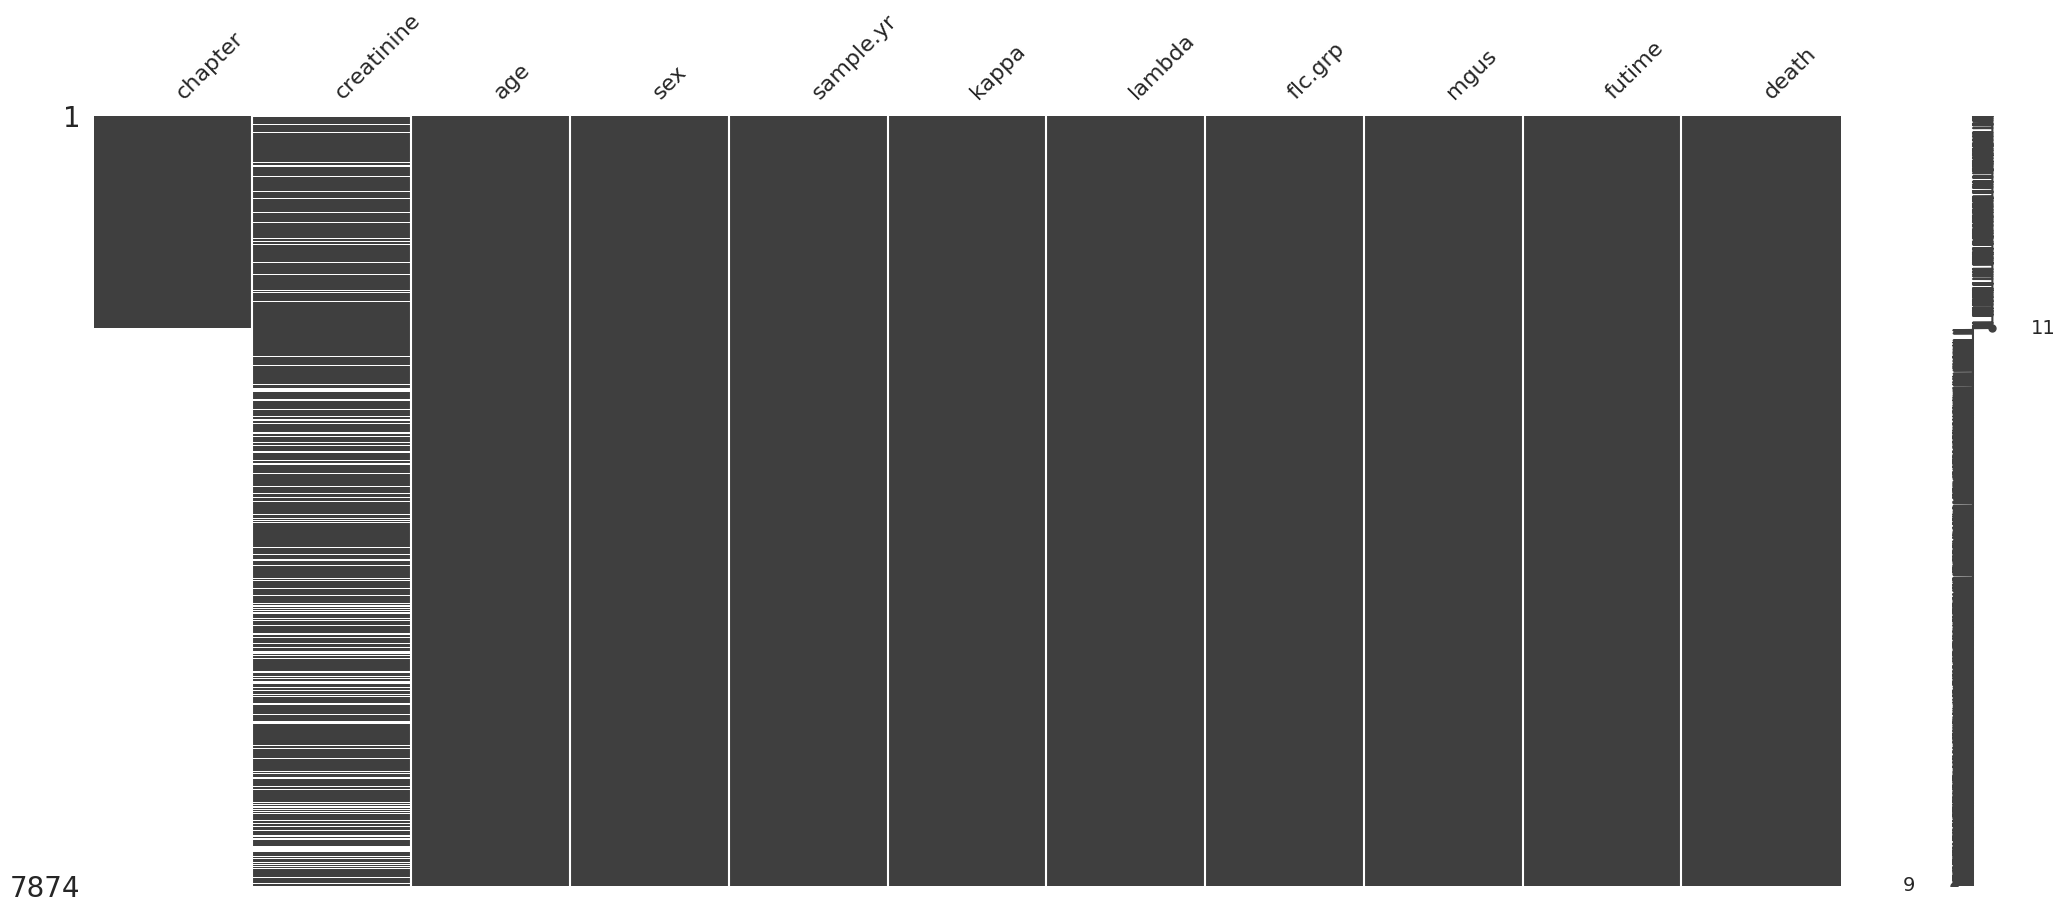

In [42]:
(
    survival_df
    .missing.sort_variables_by_missingness()
    .sort_values(by="chapter")
    .pipe(missingno.matrix)
)

In [43]:
survival_df

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death,chapter
0,97,F,1997,5.700,4.860,10,1.7,0,85,1,Circulatory
1,92,F,2000,0.870,0.683,1,0.9,0,1281,1,Neoplasms
2,94,F,1997,4.360,3.850,10,1.4,0,69,1,Circulatory
3,92,F,1996,2.420,2.220,9,1.0,0,115,1,Circulatory
4,93,F,1996,1.320,1.690,6,1.1,0,1039,1,Circulatory
...,...,...,...,...,...,...,...,...,...,...,...
7869,52,F,1995,1.210,1.610,6,1.0,0,4997,0,NaN
7870,52,F,1999,0.858,0.581,1,0.8,0,3652,0,NaN
7871,54,F,2002,1.700,1.720,8,NaN,0,2507,0,NaN
7872,53,F,1995,1.710,2.690,9,NaN,0,4982,0,NaN


In [44]:
model_1 = (
    smf.ols(
        formula = 'death ~ chapter + age + sex',
        data=survival_df
    )
    .fit()
)

model_1.summary()

/home/tux/curso-datos-faltantes-i/env/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  death   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -126.5
Date:                Sat, 09 Sep 2023   Prob (F-statistic):               1.00
Time:                        08:55:07   Log-Likelihood:                 70737.
No. Observations:                2169   AIC:                        -1.414e+05
Df Residuals:                    2151   BIC:                        -1.413e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           1.0000    8.9e-16   1.12e+15      0.000       1.000       1.000
chapter[T.Circulatory]          -2.628e-15   8.36e-16     -3.141      0.002   -4.27e-15   -9.87e-16
chapter[T.Congenital]            3.634e-15   1.27e-15      2.851      0.004    1.13e-15    6.13e-15
chapter[T.Digestive]            -2.979e-15   8.59e-16     -3.466      0.001   -4.66e-15   -1.29e-15
chapter[T.Endocrine]            -1.036e-15   8.69e-16     -1.193      0.233   -2.74e-15    6.67e-16
chapter[T.External Causes]      -1.679e-15   8.59e-16     -1.954      0.051   -3.36e-15    6.36e-18
chapter[T.Genitourinary]        -2.796e-15   8.73e-16     -3.203      0.001   -4.51e-15   -1.08e-15
chapter[T.Ill Defined]           -6.76e-16   8.77e-16     -0.771      0.441    -2.4e-15    1.04e-15
chapter[T.Infectious]           -2.156e-15   8.86e-16     -2.434      0.015   -3.89e-15   -4.19e-16
chapter[T.Injury and Poisoning] -1.017e-15    9.1e-16     -1.118      0.264    -2.8e-15    7.67e-16
chapter[T.Mental]                -1.75e-15   8.46e-16     -2.069      0.039   -3.41e-15   -9.15e-17
chapter[T.Musculoskeletal]      -3.999e-15   9.47e-16     -4.224      0.000   -5.86e-15   -2.14e-15
chapter[T.Neoplasms]            -3.511e-15   8.38e-16     -4.189      0.000   -5.15e-15   -1.87e-15
chapter[T.Nervous]              -3.073e-15   8.47e-16     -3.628      0.000   -4.73e-15   -1.41e-15
chapter[T.Respiratory]          -3.409e-15   8.41e-16     -4.053      0.000   -5.06e-15   -1.76e-15
chapter[T.Skin]                 -8.731e-16   1.18e-15     -0.740      0.459   -3.19e-15    1.44e-15
sex[T.M]                         2.834e-16   7.38e-17      3.838      0.000    1.39e-16    4.28e-16
age                              1.735e-17   3.74e-18      4.640      0.000       1e-17    2.47e-17
==============================================================================
Omnibus:                      667.920   Durbin-Watson:                   0.386
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3241.315
Skew:                          -1.386   Prob(JB):                         0.00
Kurtosis:                       8.309   Cond. No.                     6.96e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
model_2 = (
    smf.ols(
        formula = 'death ~  age + sex',
        data=survival_df
    )
    .fit()
)

model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  death   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     1627.
Date:                Sat, 09 Sep 2023   Prob (F-statistic):               0.00
Time:                        08:55:07   Log-Likelihood:                -3465.7
No. Observations:                7874   AIC:                             6937.
Df Residuals:                    7871   BIC:                             6958.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2454      0.027    -45.877      0.000      -1.299      -1.192
sex[T.M]       0.0658      0.009      7.687      0.000       0.049       0.083
age            0.0232      0.000     57.013      0.000       0.022       0.024
==============================================================================
Omnibus:                      542.474   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              662.217
Skew:                           0.710   Prob(JB):                    1.59e-144
Kurtosis:                       2.961   Cond. No.                         419.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
model_2 = (
    smf.ols(
        formula = 'death ~  age + sex + kappa + creatinine + chapter',
        data=survival_df
    )
    .fit()
)

model_2.summary()

/home/tux/curso-datos-faltantes-i/env/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  death   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -102.2
Date:                Sat, 09 Sep 2023   Prob (F-statistic):               1.00
Time:                        08:55:07   Log-Likelihood:                 61492.
No. Observations:                1962   AIC:                        -1.229e+05
Df Residuals:                    1942   BIC:                        -1.228e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           1.0000    3.2e-15   3.12e+14      0.000       1.000       1.000
sex[T.M]                         -8.83e-16   2.85e-16     -3.100      0.002   -1.44e-15   -3.24e-16
chapter[T.Circulatory]            2.76e-15   2.99e-15      0.924      0.356    -3.1e-15    8.62e-15
chapter[T.Congenital]            2.829e-15   4.61e-15      0.613      0.540   -6.22e-15    1.19e-14
chapter[T.Digestive]             2.308e-15   3.08e-15      0.750      0.453   -3.73e-15    8.34e-15
chapter[T.Endocrine]             1.265e-15   3.12e-15      0.405      0.685   -4.85e-15    7.38e-15
chapter[T.External Causes]       2.376e-15   3.08e-15      0.771      0.441   -3.67e-15    8.42e-15
chapter[T.Genitourinary]         2.625e-15   3.13e-15      0.837      0.402   -3.52e-15    8.77e-15
chapter[T.Ill Defined]           3.496e-15   3.14e-15      1.114      0.266   -2.66e-15    9.65e-15
chapter[T.Infectious]            1.733e-15    3.2e-15      0.541      0.589   -4.55e-15    8.01e-15
chapter[T.Injury and Poisoning]  4.558e-15   3.26e-15      1.397      0.163   -1.84e-15     1.1e-14
chapter[T.Mental]                2.569e-15   3.02e-15      0.849      0.396   -3.36e-15     8.5e-15
chapter[T.Musculoskeletal]       1.491e-15   3.45e-15      0.433      0.665   -5.27e-15    8.25e-15
chapter[T.Neoplasms]             1.478e-15   2.99e-15      0.494      0.622   -4.39e-15    7.35e-15
chapter[T.Nervous]               1.371e-15   3.03e-15      0.453      0.651   -4.57e-15    7.31e-15
chapter[T.Respiratory]           1.286e-15      3e-15      0.428      0.669   -4.61e-15    7.18e-15
chapter[T.Skin]                 -8.483e-16   4.21e-15     -0.201      0.840   -9.11e-15    7.41e-15
age                             -4.979e-17   1.43e-17     -3.487      0.001   -7.78e-17   -2.18e-17
kappa                           -1.198e-15   1.35e-16     -8.867      0.000   -1.46e-15   -9.33e-16
creatinine                      -3.298e-16      3e-16     -1.098      0.272   -9.19e-16    2.59e-16
==============================================================================
Omnibus:                     1299.949   Durbin-Watson:                   0.174
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26365.429
Skew:                           2.805   Prob(JB):                         0.00
Kurtosis:                      20.060   Cond. No.                     6.67e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Preparando datos: _National Health and Nutrition Examination Survey_

/home/tux/curso-datos-faltantes-i/env/lib/python3.10/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)
/home/tux/curso-datos-faltantes-i/env/lib/python3.10/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


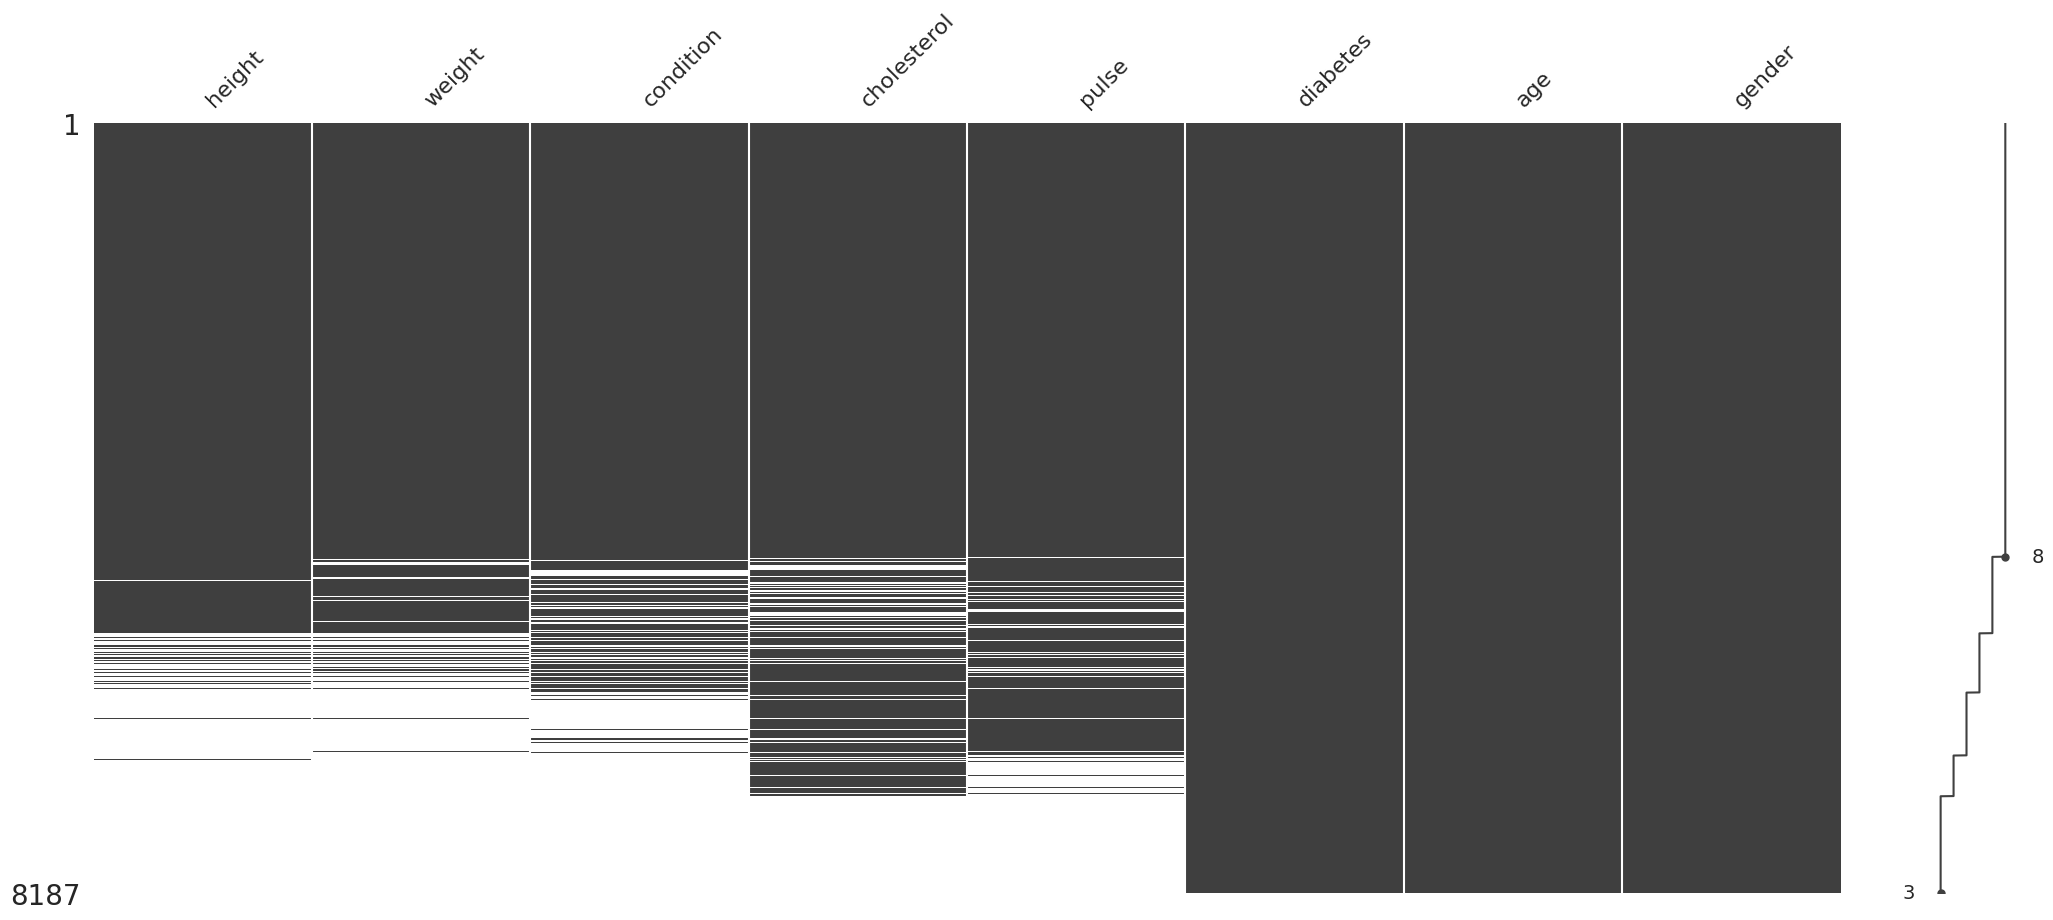

/home/tux/curso-datos-faltantes-i/env/lib/python3.10/site-packages/upsetplot/plotting.py:580: MatplotlibDeprecationWarning: The get_renderer function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.canvas.get_renderer() instead.
  window_extent_args["renderer"] = get_renderer(fig)
/home/tux/curso-datos-faltantes-i/env/lib/python3.10/site-packages/upsetplot/plotting.py:586: MatplotlibDeprecationWarning: The get_renderer function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.canvas.get_renderer() instead.
  window_extent_args["renderer"] = get_renderer(fig)


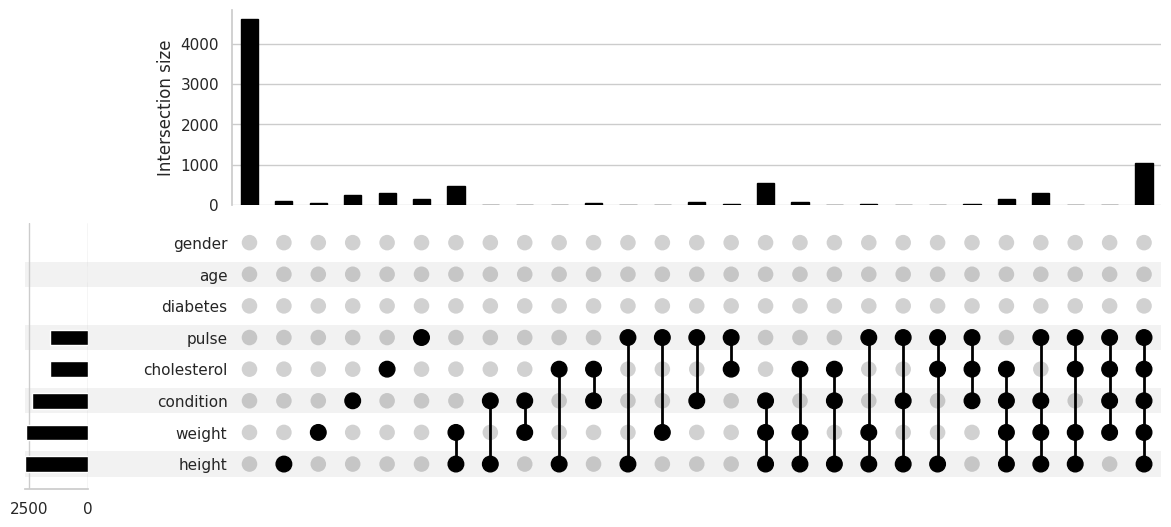

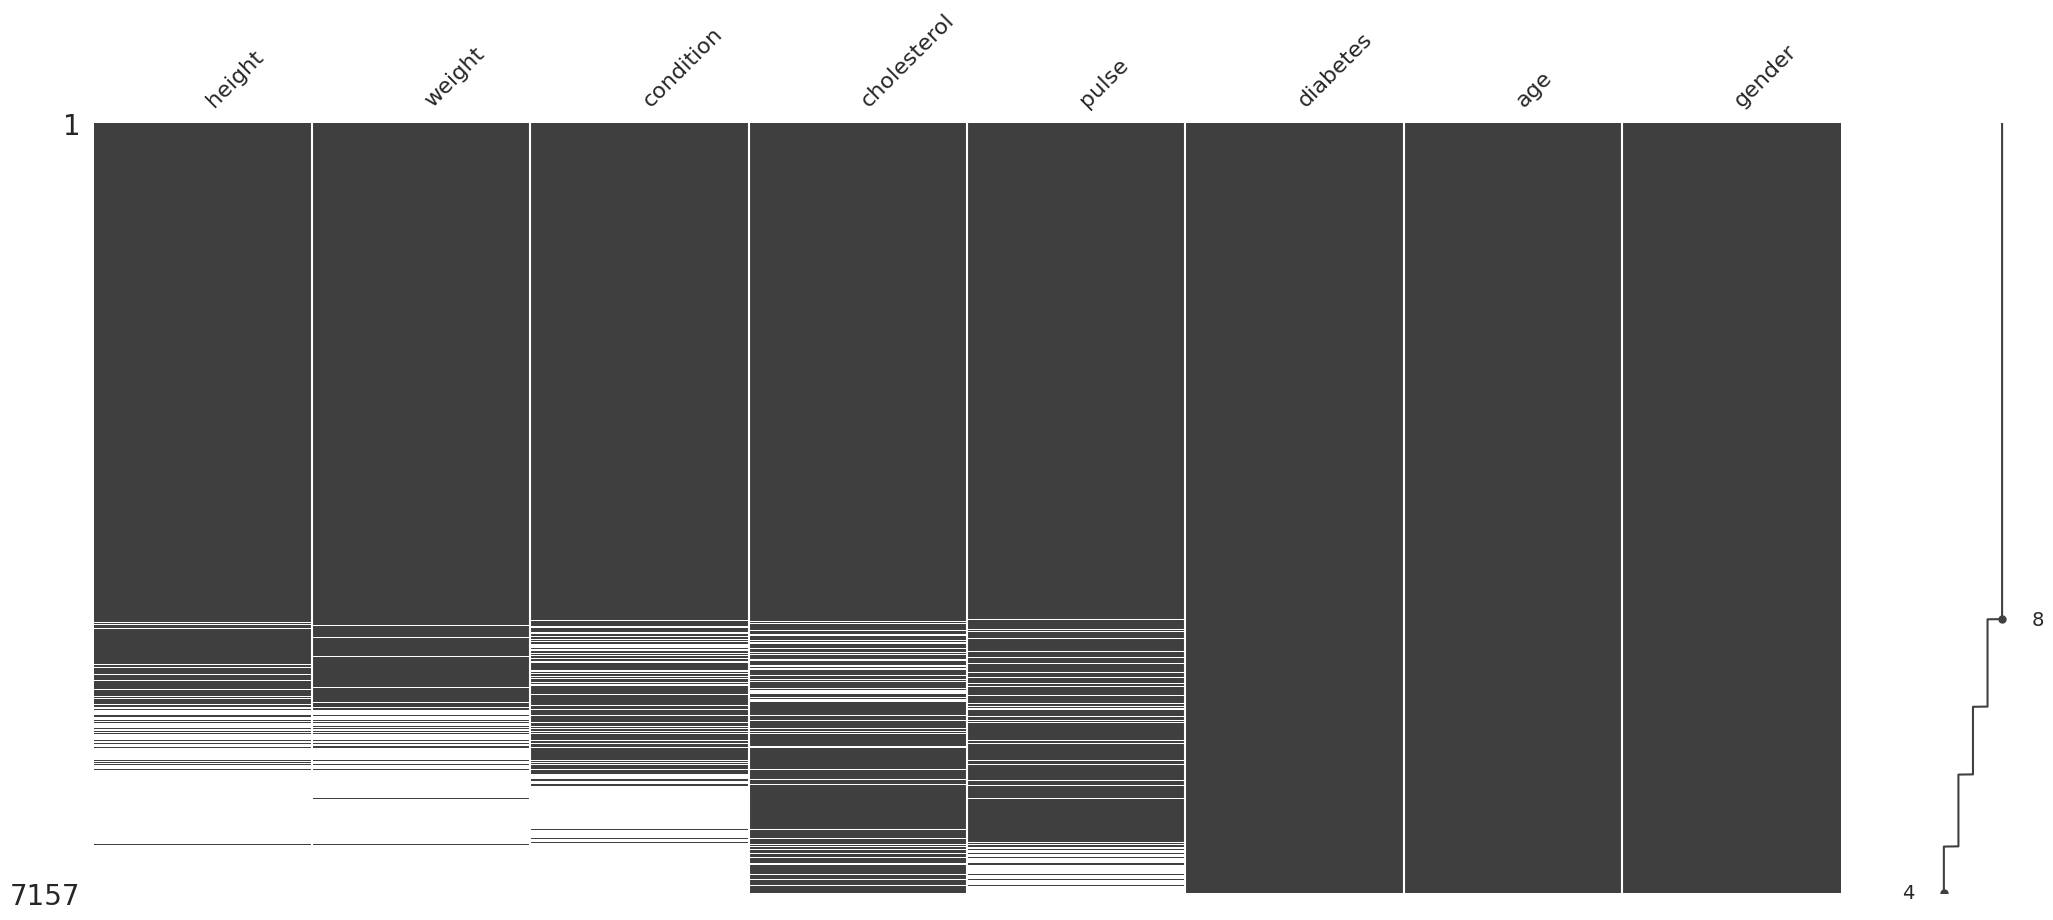

In [47]:
%run live-download-data-and-load-it.ipynb

## Consideración y evaluación de los distintos tipos de valores faltantes

![](missing_data_action.jpeg)

## Evaluación del mecanismo de valores faltantes por prueba de _t-test_

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
<code>two-sided</code>: las <b>medias</b> de las distribuciones subyacentes a las muestras son <b>desiguales</b>.<br>
<code>less</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>menor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.<br>
<code>greater</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>mayor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.<br>
    </p>
</div>

### MCAR
La localización de los valores faltantes en el conjunto de datos ocurren completamente al azar, estos no dependen de ningún otro dato

#### Eliminación de valores faltantes

Reducción del tamaño de muestra.
Inferencia limitada.
No produce sesgos
Imputación de valores faltantes

De hacerlo bien, no produce sesgos
La imputación es recomendada sobre la eliminación.

### MAR
La localización de los valores faltantes en el conjunto de datos dependen de otros valores observados.

#### Eliminación de valores faltantes

Ignorarlos produce sesgos
Imputación de valores faltantes

La mayor parte de métodos de imputación asumen MAR
La imputación es necesaria

### MNAR
La localización de los valores faltantes en el conjunto de datos dependen de otros valores faltantes en sí mismos.

#### Eliminación de valores faltantes

Ignorarlos produce sesgos
Imputación de valores faltantes

La imputación es recomendada sobre la eliminación.

La prueba t se recomienda en diversas condiciones cuando deseas comparar las medias de dos grupos o realizar una prueba de diferencia de medias. Aquí te presento algunas situaciones comunes en las que se sugiere utilizar la prueba t:

- **Comparación de dos grupos independientes:** La prueba t de dos muestras independientes es útil cuando tienes dos grupos diferentes que no están relacionados entre sí y deseas saber si hay una diferencia significativa entre sus medias. Por ejemplo, comparar las calificaciones promedio de dos grupos de estudiantes que tomaron diferentes cursos.

- **Comparación antes y después de un tratamiento o intervención:** La prueba t de dos muestras emparejadas es adecuada cuando estás interesado en evaluar si hay una diferencia significativa entre dos conjuntos de observaciones relacionadas, como el rendimiento de un grupo de individuos antes y después de recibir un tratamiento médico o una capacitación.

- **Pequeñas muestras:** La prueba t puede ser más adecuada que la prueba z (prueba de Z) cuando trabajas con muestras pequeñas (generalmente menos de 30 observaciones por grupo). Esto se debe a que la prueba t tiene en cuenta la estimación de la desviación estándar de la población a partir de las muestras, lo que puede hacer que los resultados sean más precisos en tales casos.

- **Distribución aproximadamente normal:** La prueba t es más robusta que algunas otras pruebas cuando los datos no siguen una distribución perfectamente normal, siempre que la desviación de la normalidad no sea muy extrema. Sin embargo, es importante comprobar la normalidad de los datos antes de usar la prueba t.

- **Homogeneidad de varianzas:** Aunque la prueba t puede utilizarse cuando las varianzas de los dos grupos no son iguales, es más precisa cuando las varianzas son aproximadamente iguales. Puedes realizar una prueba de homogeneidad de varianzas para verificar si esta suposición es válida.

- **Variables cuantitativas:** La prueba t se utiliza para comparar medias de variables cuantitativas o numéricas. Si estás trabajando con variables categóricas, se pueden usar otras pruebas estadísticas, como la prueba chi-cuadrado.

- **Datos independientes y aleatorios:** Asegúrate de que tus datos sean independientes y hayan sido recopilados de forma aleatoria o que el diseño del estudio justifique el uso de la prueba t.

- **Interés en la diferencia de medias:** La prueba t se utiliza específicamente para evaluar si hay una diferencia significativa entre las medias de los dos grupos. Si tu pregunta de investigación se centra en la diferencia de medias, la prueba t es apropiada.

La hipótesis nula, en el contexto de una prueba de hipótesis, suele afirmar que no hay efecto o que las poblaciones comparadas son iguales. Por ejemplo, en una prueba t de dos muestras independientes para comparar las calificaciones promedio de dos grupos de estudiantes, la hipótesis nula podría ser que no hay diferencia significativa en las calificaciones promedio entre los dos grupos.

In [48]:
female_weight, male_weight = (
    nhanes_df
    .select_columns("gender", "weight")
    .transform_column(
        "weight",
        lambda x: x.isna(),
        elementwise = False
    )
    .groupby("gender")
    .weight
    .pipe(
        lambda df: (
            df.get_group("Female"),
            df.get_group("Male")
        )
    )
)

t_statistic, p_value = scipy.stats.ttest_ind(
    a = female_weight,
    b = male_weight,
    alternative="two-sided"
)

nivel_de_significancia = 0.05

if p_value < nivel_de_significancia:
    print("Prueba t:")
    print(f"Valor t = {t_statistic:.4f}")
    print(f"Valor p = {p_value:.4f}")
    print("Se rechaza la hipótesis nula: Hay evidencia de que las medias difieren significativamente.")
else:
    print("Prueba t:")
    print(f"Valor t = {t_statistic:.4f}")
    print(f"Valor p = {p_value:.4f}")
    print("No se rechaza la hipótesis nula: No hay evidencia suficiente para afirmar que las medias difieren significativamente.")

Prueba t:
Valor t = -0.3621
Valor p = 0.7173
No se rechaza la hipótesis nula: No hay evidencia suficiente para afirmar que las medias difieren significativamente.


Una guía básica para interpretar el valor p:

Valores p altos: Los datos son probables si la hipótesis nula es verdadera. Esto significa que no hay suficiente evidencia en tus datos de muestra para rechazar la hipótesis nula.
Valores p bajos: Los datos son poco probables si la hipótesis nula es verdadera. Esto sugiere que hay suficiente evidencia en tus datos de muestra para rechazar la hipótesis nula.
Por lo general, si el valor p es menor que el nivel de significancia (a menudo 0.05), se rechaza la hipótesis nula. Sin embargo, es importante recordar que un valor p bajo no prueba que tu hipótesis alternativa sea verdadera. Simplemente sugiere que la hipótesis nula no es probable dada la evidencia de los datos1.

## Amplía tu conjunto de herramientas para explorar valores faltantes

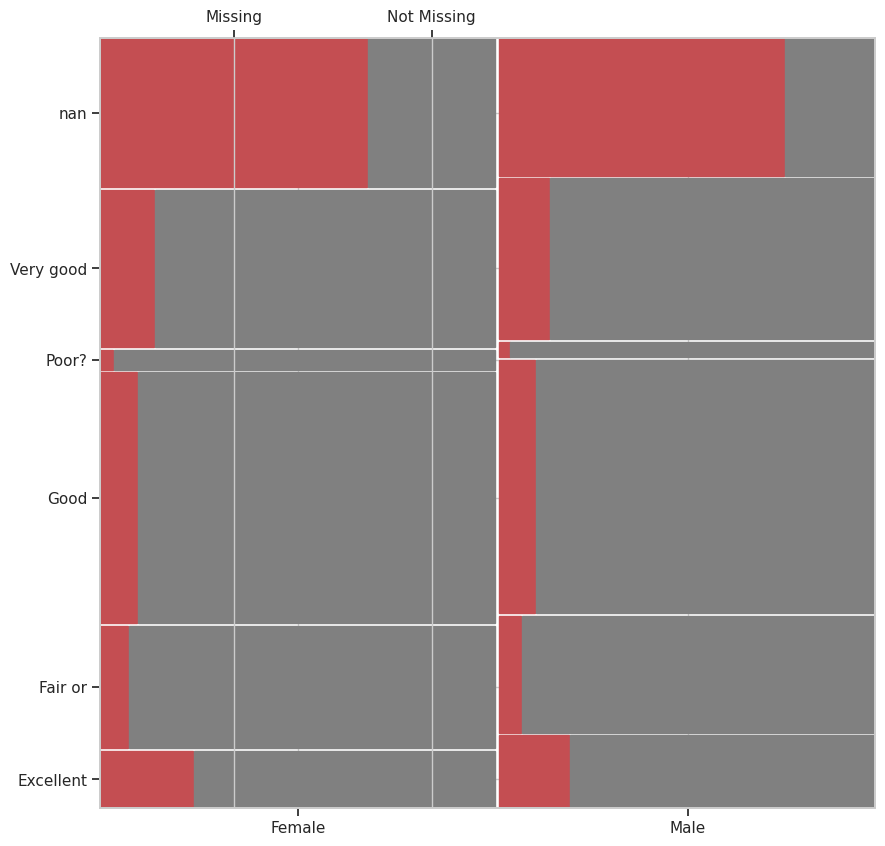

In [49]:
fig, ax = plt.subplots(figsize = (10, 10))

(
    nhanes_df
    .select_columns("weight", "condition", "gender")
    .assign(
        weight = lambda df: df.weight.isna().replace([True, False], ["Missing", "Not Missing"])
            )
    .groupby(
        ["gender", "condition", "weight"],
        dropna = False,
        as_index = True
    )
    .size()
    .pipe(
        lambda df: mosaic(
            data = df,
            properties = lambda key: {"color": "r" if "Missing" in key else "gray"},
            horizontal = True,
            axes_label = True,
            title = "",
            labelizer = lambda key: "",
            ax = ax
        )
    )
); #el ; evita que aparezca el output de texto de la celda

## Tratamiento de variables categóricas para imputación de valores faltantes

### Codificación ordinal

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
    Una codificación ordinal <b>implica</b> mapear cada etiqueta (categoría) única a un valor entero. A su vez, la codificación ordinal también es conocida como codificación entera.
    </p>
</div>

#### Ejemplo

Dado un conjunto de datos con dos características, encontraremos los valores únicos por cataracterística y los transformaremos utilizando una codificación ordinal.

#### Aplicando la codificación ordinal a todas tus variables categóricas

### _One Hot Encoding_

### `pandas.get_dummies()` vs `skelearn.preprocessing.OneHotEncoder()`

#### `pandas.get_dummies()`

#### `skelearn.preprocessing.OneHotEncoder()`

## Tipos de imputación de valores faltantes

![](imputation_methods.png)

## Imputación de un único valor (media, mediana, moda)

## Imputación por llenado hacia atrás e imputación por llenado hacia adelante

### `fillna()` vs `ffill()` o `bfill()`

#### Recomendaciones al imputar valores utilizando `ffill()` o `bfill()`

> Imputación dentro de dominios e imputación a través de variables correlacionadas

## Imputación por interpolación

## Imputación por algoritmo de vecinos más cercanos (KNN)

### Ordenamiento por cantidad de variables faltantes

## Imputación basada en modelos

## Imputaciones Múltiples por Ecuaciones Encadenadas (MICE)

## Transformación inversa de los datos

## Continúa aprendiendo sobre el manejo de valores faltantes

<div class="alert alert-success">
    <b style="font-size: 1.5em;">✅ ¡Felicidades por terminar el curso!</b>
    <p>
    ¡Tu progreso es increíble! ¡Ahora eres capaz de llevar tus análisis al siguiente nivel! La barrera de los valores faltantes ya no es una limitante extrema para tu trabajo. Tú puedes explorar valores faltantes, eliminarlos e imputarlos siendo consciente de las ventajas y desventajas de cada método elegido. ¡Fantástico!
    </p>
    <p>
    <b>¿Cómo puedo continuar mi aprendizaje en el análisis de valores faltantes?</b>
    Poner en práctica lo aprendido es una excelente opción. Por lo tanto, te recomiendo repetir este curso utilizando la totalidad de los datos del <i>National Health and Nutrition Examination Survey</i>. Con este proyecto, serás capaz de explorar y analizar una cantidad de valores faltantes variadas. Podrás probar distintos algoritmos y estrategias. 
    </p>
    <p>
    De tal forma de que, una vez consigas tu conjunto de datos final, puedas proceder a la exploración definitiva del conjunto de datos para extraer ideas y respuestas a preguntas de tu interés. Incluso, y por qué no, podrías explorar la posibilidad de crear modelos predictivos para la diabetes. Las opciones son ilimitadas. Bienvenido al mundo de la Ciencia de Datos.
    </p>
    <p>
    Con mucha alegría por tu logro,
    Jesús Vélez Santiago
    </p>
</div>

## Información de sesión

In [51]:
session_info.show()

/home/tux/curso-datos-faltantes-i/env/lib/python3.10/site-packages/session_info/main.py:213: DeprecationWarning: Accessing attrs.__version__ is deprecated and will be removed in a future release. Use importlib.metadata directly to query for attrs's packaging metadata.
  mod_version = _find_version(mod.__version__)
/home/tux/curso-datos-faltantes-i/env/lib/python3.10/site-packages/session_info/main.py:213: DeprecationWarning: Accessing jsonschema.__version__ is deprecated and will be removed in a future release. Use importlib.metadata directly to query for jsonschema's version.
  mod_version = _find_version(mod.__version__)
/home/tux/curso-datos-faltantes-i/env/lib/python3.10/site-packages/session_info/main.py:213: DeprecationWarning: Accessing attr.__version__ is deprecated and will be removed in a future release. Use importlib.metadata directly to query for attrs's packaging metadata.
  mod_version = _find_version(mod.__version__)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bdf84ff9-f66c-44c7-a67c-ca1115a2b683' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>